<a href="https://colab.research.google.com/github/bleamer/eva5/blob/master/W5/MNIST_S2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This notebook implements a CNN to classify MNIST image dataset

[Summary](#scrollTo=_-dP1v2XvuJe) at the bottom of the notebook

In [24]:
targets = '''
1. Reduce no. of trainable parameters to < 10,000, by reworking the number of channels
1. Break code into transformation blocks
1. Set Transforms, but not use any image transform
1. Maintain train and test accuracy above 98.5%
1. Allow some overfitting
'''

# Import Libraries

In [42]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import numpy as np


## Data Transformations

We first start with defining our data transformations. We need to think what our data is and how can we augment it to correct represent images which it might not see otherwise. 

Here is the list of all the transformations which come pre-built with PyTorch

1.   Compose
2.   ToTensor
3.   ToPILImage
4. Normalize
5. Resize
6. Scale
7. CenterCrop
8. Pad
9. Lambda
10. RandomApply
11. RandomChoice
12. RandomOrder
13. RandomCrop
14. RandomHorizontalFlip
15. RandomVerticalFlip
16. RandomResizedCrop
17. RandomSizedCrop
18. FiveCrop
19. TenCrop
20. LinearTransformation
21. ColorJitter
22. RandomRotation
23. RandomAffine
24. Grayscale
25. RandomGrayscale
26. RandomPerspective
27. RandomErasing

You can read more about them [here](https://pytorch.org/docs/stable/_modules/torchvision/transforms/transforms.html)

In [26]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])


# Dataset and Creating Train/Test Split

In [27]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

# Dataloader Arguments & Test/Train Dataloaders


In [28]:
SEED = 1

import psutil
CPU_COUNT =  psutil.cpu_count()

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=CPU_COUNT, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


# Data Statistics

It is important to know your data very well. Let's check some of the statistics around our data and how it actually looks like

/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:55: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


[Train]
 - Numpy Shape: (60000, 28, 28)
 - Tensor Shape: torch.Size([60000, 28, 28])
 - min: tensor(-0.4242)
 - max: tensor(2.8215)
 - mean: tensor(-0.0002)
 - std: tensor(1.0000)
 - var: tensor(1.0001)
torch.Size([128, 1, 28, 28])
torch.Size([128])


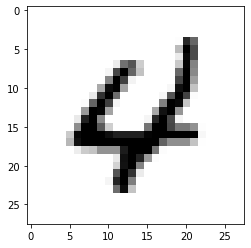

In [29]:
# We'd need to convert it into Numpy! Remember above we have converted it into tensors already
train_data = train.train_data
train_data = train.transform(train_data.numpy())

print('[Train]')
print(' - Numpy Shape:', train.train_data.cpu().numpy().shape)
print(' - Tensor Shape:', train.train_data.size())
print(' - min:', torch.min(train_data))
print(' - max:', torch.max(train_data))
print(' - mean:', torch.mean(train_data))
print(' - std:', torch.std(train_data))
print(' - var:', torch.var(train_data))

dataiter = iter(train_loader)
images, labels = dataiter.next()

print(images.shape)
print(labels.shape)

# Let's visualize some of the images
%matplotlib inline
import matplotlib.pyplot as plt

plt.imshow(images[100].numpy().squeeze(), cmap='gray_r')


## MORE

It is important that we view as many images as possible. This is required to get some idea on image augmentation later on

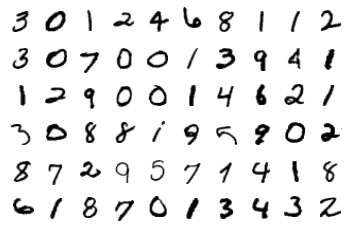

In [30]:
figure = plt.figure()
num_of_images = 60
for index in range(1, num_of_images + 1):
    plt.subplot(6, 10, index)
    plt.axis('off')
    plt.imshow(images[index].numpy().squeeze(), cmap='gray_r')

# How did we get those mean and std values which we used above?

Let's run a small experiment

In [31]:
# simple transform
simple_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                      #  transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])
exp = datasets.MNIST('./data', train=True, download=True, transform=simple_transforms)
exp_data = exp.train_data
exp_data = exp.transform(exp_data.numpy())

print('[Train]')
print(' - Numpy Shape:', exp.train_data.cpu().numpy().shape)
print(' - Tensor Shape:', exp.train_data.size())
print(' - min:', torch.min(exp_data))
print(' - max:', torch.max(exp_data))
print(' - mean:', torch.mean(exp_data))
print(' - std:', torch.std(exp_data))
print(' - var:', torch.var(exp_data))

/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:55: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


[Train]
 - Numpy Shape: (60000, 28, 28)
 - Tensor Shape: torch.Size([60000, 28, 28])
 - min: tensor(0.)
 - max: tensor(1.)
 - mean: tensor(0.1305)
 - std: tensor(0.3081)
 - var: tensor(0.0949)


# The model
Let's start with the model we first saw

In [32]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Input Block
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
            
            nn.ReLU()
        ) # output_size = 26, Receptive Field = 3

        # CONVOLUTION BLOCK 1
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
            
            nn.ReLU()
        ) # output_size = 24 Receptive Field = 5
        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU()
        ) # output_size = 22 Receptive Field = 7

        #------------------------------------------

        # TRANSITION BLOCK 1
        self.pool1 = nn.MaxPool2d(2, 2) # output_size = 11 Receptive Field = 14
        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
            nn.ReLU()
        ) # output_size = 11 Receptive Field = 14

        # CONVOLUTION BLOCK 2
        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
            
            
            nn.ReLU()
        ) # output_size = 9 Receptive Field = 16
        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU()
        ) # output_size = 7 Receptive Field = 18

        #-------------------------------------------

        # OUTPUT BLOCK
        self.convblock7 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
            nn.ReLU()
        ) # output_size = 7 Receptive Field = 20
        self.convblock8 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(7, 7), padding=0, bias=False),
            # nn.BatchNorm2d(10), NEVER
            # nn.ReLU() NEVER!
        ) # output_size = 1 Receptive Field = 28

    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.convblock3(x)
        x = self.pool1(x)
        x = self.convblock4(x)
        x = self.convblock5(x)
        x = self.convblock6(x)
        x = self.convblock7(x)
        x = self.convblock8(x)
        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

# Model Params
Can't emphasize on how important viewing Model Summary is. 
Unfortunately, there is no in-built model visualizer, so we have to take external help

In [33]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 10, 26, 26]              90
              ReLU-2           [-1, 10, 26, 26]               0
            Conv2d-3           [-1, 10, 24, 24]             900
              ReLU-4           [-1, 10, 24, 24]               0
            Conv2d-5           [-1, 16, 22, 22]           1,440
              ReLU-6           [-1, 16, 22, 22]               0
         MaxPool2d-7           [-1, 16, 11, 11]               0
            Conv2d-8           [-1, 10, 11, 11]             160
              ReLU-9           [-1, 10, 11, 11]               0
           Conv2d-10             [-1, 10, 9, 9]             900
             ReLU-11             [-1, 10, 9, 9]               0
           Conv2d-12             [-1, 16, 7, 7]           1,440
             ReLU-13             [-1, 16, 7, 7]               0
           Conv2d-14             [

# Training and Testing


Let's write train and test functions

In [34]:
from tqdm import tqdm
from tqdm.notebook import tqdm as tqdmn

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Training Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Test Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))

# Let's Train and test our model

In [35]:
model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
EPOCHS = 15
for epoch in tqdmn(range(EPOCHS)):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)

  0%|          | 0/469 [00:00<?, ?it/s]

EPOCH: 0


Loss=0.24045060575008392 Batch_id=468 Training Accuracy=44.06: 100%|██████████| 469/469 [00:17<00:00, 27.31it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.3088, Test Accuracy: 9051/10000 (90.51%)

EPOCH: 1


Loss=0.23445886373519897 Batch_id=468 Training Accuracy=93.07: 100%|██████████| 469/469 [00:17<00:00, 26.90it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1442, Test Accuracy: 9557/10000 (95.57%)

EPOCH: 2


Loss=0.09776825457811356 Batch_id=468 Training Accuracy=96.06: 100%|██████████| 469/469 [00:17<00:00, 27.33it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1360, Test Accuracy: 9575/10000 (95.75%)

EPOCH: 3


Loss=0.12815748155117035 Batch_id=468 Training Accuracy=97.08: 100%|██████████| 469/469 [00:17<00:00, 27.39it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0800, Test Accuracy: 9759/10000 (97.59%)

EPOCH: 4


Loss=0.008090650662779808 Batch_id=468 Training Accuracy=97.70: 100%|██████████| 469/469 [00:17<00:00, 27.30it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0744, Test Accuracy: 9762/10000 (97.62%)

EPOCH: 5


Loss=0.007101721595972776 Batch_id=468 Training Accuracy=98.07: 100%|██████████| 469/469 [00:17<00:00, 27.24it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0551, Test Accuracy: 9837/10000 (98.37%)

EPOCH: 6


Loss=0.03554815426468849 Batch_id=468 Training Accuracy=98.29: 100%|██████████| 469/469 [00:17<00:00, 27.21it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0499, Test Accuracy: 9840/10000 (98.40%)

EPOCH: 7


Loss=0.029291493818163872 Batch_id=468 Training Accuracy=98.42: 100%|██████████| 469/469 [00:17<00:00, 27.14it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0484, Test Accuracy: 9854/10000 (98.54%)

EPOCH: 8


Loss=0.007687192410230637 Batch_id=468 Training Accuracy=98.60: 100%|██████████| 469/469 [00:17<00:00, 27.16it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0436, Test Accuracy: 9857/10000 (98.57%)

EPOCH: 9


Loss=0.016227925196290016 Batch_id=468 Training Accuracy=98.64: 100%|██████████| 469/469 [00:17<00:00, 27.25it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0482, Test Accuracy: 9837/10000 (98.37%)

EPOCH: 10


Loss=0.02380424179136753 Batch_id=468 Training Accuracy=98.70: 100%|██████████| 469/469 [00:17<00:00, 27.30it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0433, Test Accuracy: 9867/10000 (98.67%)

EPOCH: 11


Loss=0.05665721371769905 Batch_id=468 Training Accuracy=98.78: 100%|██████████| 469/469 [00:17<00:00, 27.23it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0404, Test Accuracy: 9872/10000 (98.72%)

EPOCH: 12


Loss=0.02045566402375698 Batch_id=468 Training Accuracy=98.86: 100%|██████████| 469/469 [00:17<00:00, 27.22it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0412, Test Accuracy: 9857/10000 (98.57%)

EPOCH: 13


Loss=0.010371263138949871 Batch_id=468 Training Accuracy=98.90: 100%|██████████| 469/469 [00:17<00:00, 27.26it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0405, Test Accuracy: 9874/10000 (98.74%)

EPOCH: 14


Loss=0.010698248632252216 Batch_id=468 Training Accuracy=98.96: 100%|██████████| 469/469 [00:17<00:00, 27.18it/s]



Test set: Average loss: 0.0428, Test Accuracy: 9856/10000 (98.56%)




Text(0.5, 1.0, 'Test Accuracy')

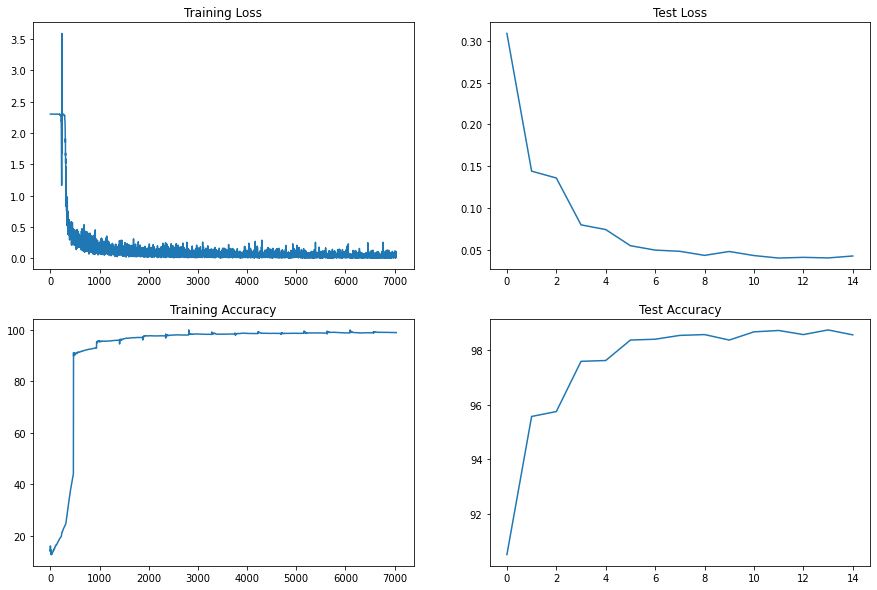

In [36]:
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")

In [44]:
Analysis ='''
1. No. of parameter have been reduced to < 10,000 
1. Model accuracy has reduced to ~ 98.5 - 99%
1. Reduced model footprint 
1. Training accuracy ~99%, but test accuracy ~98.5% leaves room for model improvement
1. Model still shows overfitting since Training accuracy is higher than test accuracy
'''

In [45]:
total_params = sum(param.numel() for name, param in  model.named_parameters())

#Summary

In [46]:
from IPython.display import Markdown as md


md(f"""

<h2>Summary</h2>

**Targets**:   {targets} 

----
| Attribute | Value |
|:--- | :--- |
| Training Accuracy | {np.mean(train_acc[-3:])} |
| Test Accuracy | {np.mean(test_acc[-3:])} |
| Trained Parameter count   |{total_params} |
| Total Epochs | {EPOCHS} |

----
**Analysis**: {Analysis}
""")




<h2>Summary</h2>

**Targets**:   
1. Reduce no. of trainable parameters to < 10,000, by reworking the number of channels
1. Break code into transformation blocks
1. Set Transforms, but not use any image transform
1. Maintain train and test accuracy above 98.5%
1. Allow some overfitting
 

----
| Attribute | Value |
|:--- | :--- |
| Training Accuracy | 98.9603726485813 |
| Test Accuracy | 98.62333333333333 |
| Trained Parameter count   |9990 |
| Total Epochs | 15 |

----
**Analysis**: 
1. No. of parameter have been reduced to < 10,000 
1. Model accuracy has reduced to ~ 98.5 - 99%
1. Reduced model footprint 
1. Training accuracy ~99%, but test accuracy ~98.5% leaves room for model improvement
1. Model still shows overfitting since Training accuracy is higher than test accuracy

